In [1]:
import pandas as pd
import numpy as np
from tensorflow.python.ops import nn_ops, gen_nn_ops
import tensorflow as tf

/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3

In [2]:
class CNN_MC_dropout:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32)
            self.is_dropout = tf.placeholder(tf.bool)
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.round(self.prediction),self.y)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 128, [8,1], padding='SAME')
            self.batch1 = tf.layers.batch_normalization(self.conv1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 256, [5,1], padding='SAME')
            self.batch2 = tf.layers.batch_normalization(self.conv2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 128, [3,1], padding='SAME')
            self.batch3 = tf.layers.batch_normalization(self.conv3)
            self.relu3 = tf.nn.relu(self.batch3)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            #Global Average Pooling
            self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.GAP,self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob,is_dropout):
        opt, cost ,acc = self.sess.run((self.optimizer, self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def test(self, data, target, keep_prob,is_dropout):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def get_last_conv_output(self, data, keep_prob,is_dropout):
        relu3 =  self.sess.run((self.relu3), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return relu3
    
    def predict(self, data, keep_prob,is_dropout):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph() 

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [3]:
import os

In [4]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter = ',')
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

In [5]:
from pandas import read_csv
from numpy import dstack


    
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [6]:
data_path ="/home/gin908/data/UCI HAR Dataset/"

# load all train
trainx, trainy = load_dataset('train', data_path)
batch_size = min(int(trainx.shape[0]/10), 16)
print ("batch size:{}".format(batch_size))

print(trainx.shape, trainy.shape)
# load all test
testx, testy = load_dataset('test', data_path)
print(testx.shape, testy.shape)

batch size:16
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


In [7]:
from pandas import DataFrame
# summarize the balance of classes in an output variable column
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [8]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222


In [9]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (7352, 6)
y test shape: (2947, 6)


In [10]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(7352, 1, 128, 9)
trainY shape:(7352, 6)
validX shape:(1473, 1, 128, 9)
validY shape:(1473, 6)
testX shape:(1474, 1, 128, 9)
testY shape:(1474, 6)


In [11]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 128
input_channel 9


# 2. Training condition 정의

In [12]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500


std= 0.01
l_rate = 1e-5

In [13]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [14]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

6


In [15]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [16]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 128, 9), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/dropout/mul:0", shape=(?, 1, 128, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/dropout/mul:0", shape=(?, 1, 128, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 128, 128), dtype=float32)
[layer4]
Tensor("layer4/Mean:0", shape=(?, 128), dtype=flo

# 4. Training

In [17]:
import time

In [18]:
save_path = '/data2/gin/savedmodel'
model_name = 'ICML(UCR-HAR)_CNN_MCdropout_'+str(l_rate)+'_'+str(batch_size)
print (model_name)

ICML(UCR-HAR)_CNN_MCdropout_1e-05_16


In [19]:
def get_batch(X, Y,  batch_size=1024, shuffle=False):
    """
    dataset: numpy ndarray. dim=2
    
    dataset_input = normalized_data[:, input_idx]
    dataset_target = normalized_data[:, target_idx]
    interested_indices = train_indices
    """    
    assert np.isnan(X).any()==False
    assert np.isnan(Y).any()==False
    
    interested_indices = range(0,len(X))

    if shuffle:
        np.random.shuffle(interested_indices)
        
    for i in range(0, len(X)-batch_size, batch_size):
        batch_Xlist = []
        batch_Ylist = [] 
        
        batch_indices = interested_indices[i:i+batch_size]

        batch_Xlist.append(X[batch_indices])
        batch_Ylist.append(Y[batch_indices])

            
        batch_Xlist = np.asarray(batch_Xlist)
        batch_Xlist = batch_Xlist.reshape(-1,X.shape[1],X.shape[2],X.shape[3])
        
        batch_Ylist = np.asarray(batch_Ylist)
        batch_Ylist = batch_Ylist.reshape(-1,nb_classes)

        yield batch_Xlist, batch_Ylist

In [20]:
keep_prob =1.0

for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


train_history.to_csv(os.path.join(save_path, model_name, "history_train.csv"))
valid_history.to_csv(os.path.join(save_path, model_name, "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [21]:
train_history = pd.read_csv(os.path.join(save_path, model_name, "history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path, model_name, "history_valid.csv"),index_col=0)

In [22]:
import matplotlib.pyplot as plt 

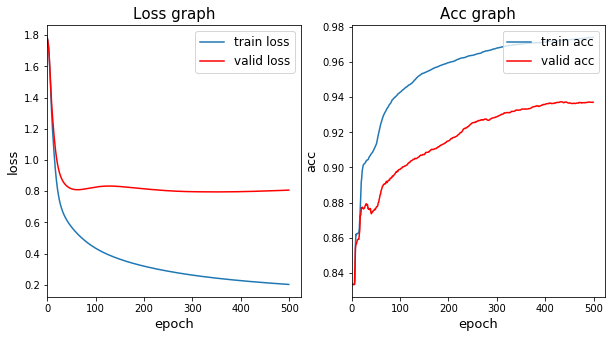

In [23]:
#Loss graph
%matplotlib inline

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train_history['loss'].tolist(), label='train loss')
ax.plot(valid_history['loss'].tolist(), label='valid loss', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Loss graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss', fontsize=13)

plt.savefig(os.path.join(save_path, model_name, 'loss_graph.png'))

ax = fig.add_subplot(1,2,2)
ax.plot(train_history['acc'].tolist(), label='train acc')
ax.plot(valid_history['acc'].tolist(), label='valid acc', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Acc graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('acc', fontsize=13)


plt.savefig(os.path.join(save_path, model_name, 'acc_graph.png'))


In [24]:
bestepoch = int(np.argmin(valid_history['loss']))

/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


In [25]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.7950858847238835


In [26]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path, model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from /data2/gin/savedmodel/ICML(UCR-HAR)_CNN_MCdropout_1e-05_16/346.ckpt
Model restored


### with confusion matrix

In [27]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    plt.subplot(122)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

In [28]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

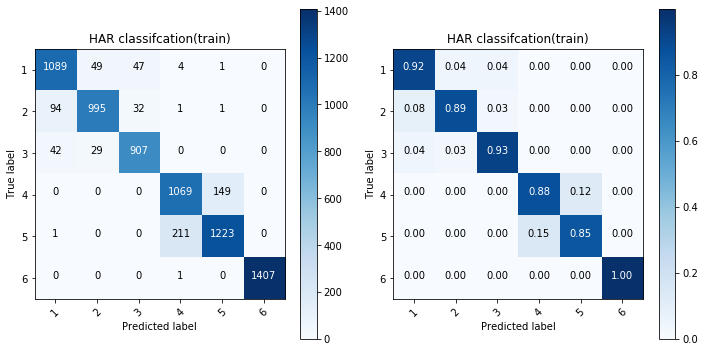

In [29]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title='HAR classifcation(train)')

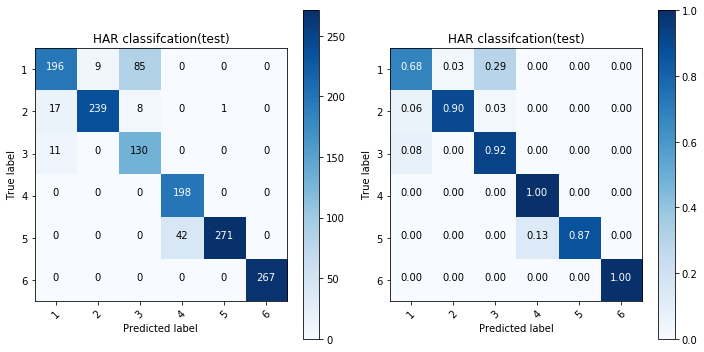

In [30]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title='HAR classifcation(test)')

# 6. Trained 된 모델에서 Last Conv output Load하기(MC dropout적용안됨)
기존논문에서 이미지타겟으로 p(A>T)=0.005 인것과 비교하여, 시계열에서는 조금 더 낮은 threshold가 패턴을 보기에 필요함.
현재 p(A>T) = 0.05로 조정되어있음

In [31]:
import random

In [32]:
last_conv_output = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
last_conv_output.shape
threshold = np.percentile(last_conv_output,95)
print ("threshold: {}".format(threshold))

threshold: 3.712264060974121


In [33]:
#trainX를 인풋으로 넣었을 때, last conv layer 의 focused_conv_channel output 보기
last_conv_bool = last_conv_output>threshold
print (last_conv_bool.shape)

(7352, 128, 128)


# 7.Result Visualization
세로축(데이터) , 가로축(마지막 컨볼루션 채널) : 데이터와 별개로 각 채널마다 일관성있게 threshold를 넘은 구간이 존재함

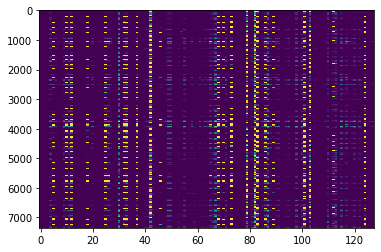

In [34]:
plt.imshow(last_conv_bool.sum(axis=1),aspect ="auto")

## 패턴의 연속성

In [35]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

In [36]:
from itertools import groupby
from operator import itemgetter

In [37]:
consecutive_num =trainX.shape[2]//20
consecutive_num

6

### plotly visualization을 위해 샘플 데이터 및 패턴 저장

In [51]:
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]

In [74]:
sample_data_idx=87
sample_output_channel = 79
sample_data = pd.DataFrame(trainX[sample_data_idx].reshape(-1,9))

In [75]:
sample_pattern_bool =pd.DataFrame(last_conv_bool[sample_data_idx][:,sample_output_channel])
pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx][:,sample_output_channel]) if x]

In [76]:
last_conv_bool[sample_data_idx][:,sample_output_channel].sum()

24

In [77]:
groups = []
for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
    groups.append(list(g))    # Store group iterator as a list

In [78]:
consecutive_pattern=[]
for g in groups:
    if len(g)>consecutive_num:
        consecutive_pattern.extend(g)
        
consecutive_pattern_bool=[]
for x in range(0,128):
    if x in np.asarray(consecutive_pattern).flatten():
        consecutive_pattern_bool.append(True)
    else:
        consecutive_pattern_bool.append(False)

In [79]:
sample_consecutive_pattern_bool= pd.DataFrame(consecutive_pattern_bool)

sample_data.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_data.csv')
sample_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_pattern.csv')
sample_consecutive_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_consecutive_pattern.csv')

In [86]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

DEFAULT_PLOTLY_COLORS=['rgba(31, 119, 180, {})', 'rgba(255, 127, 14, {})',
                       'rgba(44, 160, 44, {})', 'rgba(214, 39, 40, {})',
                       'rgba(148, 103, 189, {})', 'rgba(140, 86, 75, {})',
                       'rgba(227, 119, 194, {})', 'rgba(127, 127, 127, {})',
                       'rgba(188, 189, 34, {})', 'rgba(23, 190, 207, {})']

normalized_data = (sample_data.values - sample_data.values.min(axis=0))/(sample_data.values.max(axis=0) - sample_data.values.min(axis=0))
for cidx in range(0,sample_data.shape[1]):
    normalized_data[:,cidx] =normalized_data[:,cidx] + cidx 
    
    
fig = make_subplots(
    rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02
)

for cidx in range(sample_data.shape[-1]):
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0]), 
                             y=normalized_data[:,cidx],  
                            line_color="black",
                             line_width=1,
                             showlegend=False,
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0])[consecutive_pattern_bool], 
                            y=normalized_data[consecutive_pattern_bool,cidx],  
#                               fill='toself',
                            line_color='rgba(200, 0, 200, 0.6)',
                            line_width=5,
                            showlegend=False,
                            ),
                   row=1, col=1)
    
fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks="inside")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black',
                 ticks="inside",nticks=sample_data.shape[1], tickwidth=2, tickcolor='black', ticklen=10,title_text='Input Channel',
                showgrid=True, gridwidth=1, gridcolor='grey',
                ticktext=["Channel1", "Channel2", "Channel3", "Channel4","Channel5", "Channel6", "Channel7", "Channel8", "Channel9"],
                tickvals=["1", "2", "3", "4", "5", "6","7", "8", "9"],
                range=[0,9])


fig.update_layout(height=600, width=800,plot_bgcolor='rgb(256,256,256)',
                  title_text="Input")

fig.show()

3d plot? 수정필요

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
random.seed = 10005

class_color= ["cyan","orange","lime","pink","cyan","orange","lime","pink","cyan"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred","dodgerblue","coral","seagreen","indianred","dodgerblue"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,1)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],1)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    for c in range(0,input_channel):
        data = trainX[sample_data_idx,:,:,c].reshape(-1,1)
        data = (data-data.min())/(data.max()-data.min())
        pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx[0],:,c]) if x]
        #ax = fig.gca(projection='3d')

        ax.plot([c]*len(data),range(0,len(data)), data.flatten())
        # 패턴의 연속성을 찾는 구간
        groups = []
        for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
            groups.append(list(g))    # Store group iterator as a list
        for g in groups:
            if len(g)>consecutive_num:
                ax.scatter([c]*len(g) ,g,data[g],color = consecutive_class_color[c], s =12,alpha=0.7)
                ax.add_collection3d(plt.fill_between(np.arange(g[0],g[-1]),data[g[0]:g[-1]],0), zs=1, zdir='y')
                #ax[j].text(g[0],0,len(g))
            #else:
                #ax.scatter(g,[c]*len(g), data[g],color = class_color[c],s=12)
                
        ax.set_xticks=[]
        ax.set_yticks=[]

### 여러개의 데이터 클래스별

수정필요

In [ ]:
random.seed = 10005

class_color= ["cyan","orange","lime","pink","cyan","orange","lime","pink"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred","dodgerblue","coral","seagreen","indianred"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,10)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],10)
    fig, ax = plt.subplots(len(sample_channel), len(sample_data_idx), sharex='col', sharey='row')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    ax_idx = 0
    for i, x_idx in enumerate(sample_data_idx):
        for j,channel in enumerate(sample_channel) : 
            data = trainX[x_idx,:,:,1].reshape(-1,1)
            pattern_idx = [p for p, x in enumerate(last_conv_bool[x_idx,:,channel]) if x]
            
            # 패턴의 연속성을 찾는 구간
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
    
            ax[j,i].set_xticks=[]
            ax[j,i].set_yticks=[]
            ax[j,i].plot(data,color='black')
            for g in groups:
                if len(g)>consecutive_num:
                    ax[j,i].scatter(g, data[g],color = consecutive_class_color[class_i-1], s =12,alpha=0.7)
                    ax[j,i].text(g[0],0,len(g))
                else:
                    ax[j,i].scatter(g, data[g],color = class_color[class_i-1],s=12)